# Cross-correlation and Requirements for Approaching Unbiased Estimator CRB Limits

Cross-correlation and generalized cross-correlation is often used to estimate TDOA in passive sensor scenarios, with no prior knowledge of the signal (blind estimation).
In such cases, we would like to find out which factors affect the bias of the estimate, and the degree to which it approaches the unbiased estimator CRB limit, if any.

Let's start by creating a short signal and performing the generalized cross-correlation to scan subsample TDOA. We will not use any noise here, so we would expect the results to be perfect or near perfect.

Note that we generate the received signal using a highly super-sampled version of the original signal, and then interpolate from that to 'receive' a reasonable sample rate version of the signal at our 'receivers'.

Cupy not found. Ignoring cupy imports.
Signal duration = 0.100000s.
Tau1 = 0.000000s
Tau2 = 0.000150s
Sample-level time resolution = 0.000500s


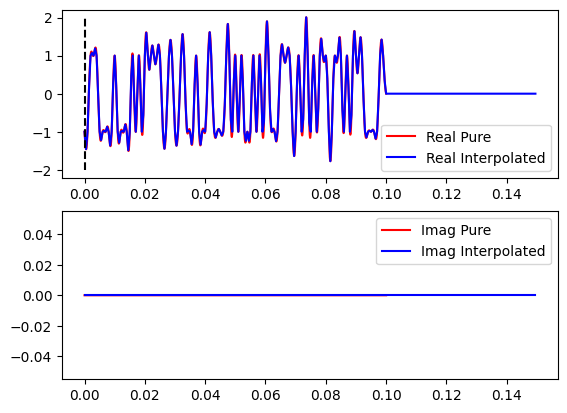

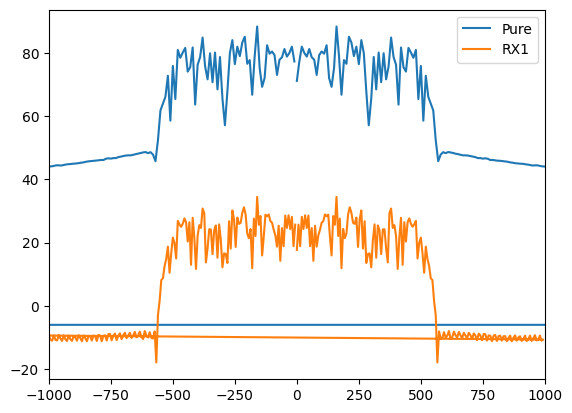

In [1]:
from signalCreationRoutines import *
from plotRoutines import *

import scipy.signal as sps

# Parameters
length = 100
baud = 1000
m = 2
duration = length/baud
print("Signal duration = %fs." % (duration))

# Pure, high oversampled version of the signal
pure_OSR = 1000
pure_fs = pure_OSR * baud

# Sample rates at receiver
fs_OSR = 2
fs = fs_OSR * baud
ftap = sps.firwin(64, baud/fs)

tau1 = 0.0 / fs
tau2 = 0.3 / fs

t = np.arange(int((1.5 * length / baud) * fs)) / fs

# Main generation function
def test_generate(length, baud, m, duration,
                  pure_OSR, pure_fs,
                  t,
                  tau1, tau2):
    
    # Create some symbols
    syms, bits = randPSKsyms(length, m)

    # Resample to a high OSR to allow interpolation
    sig = sps.resample_poly(syms, pure_OSR, 1)
    tp = np.arange(sig.size) / pure_fs

    # Sample the signal at a reasonable OSR, to two receivers
    rx1 = np.interp(t-tau1, tp, sig, left=0, right=0)
    rx2 = np.interp(t-tau2, tp, sig, left=0, right=0)

    return syms, sig, tp, rx1, rx2

# Generate once to test
syms, sig, tp, rx1, rx2 = test_generate(length, baud, m, duration,
                                        pure_OSR, pure_fs,
                                        t,
                                        tau1, tau2)

# Plot the signal?
fig, ax = plt.subplots(2,1)
ax[0].plot(tp, np.real(sig), 'r-', label='Real Pure')
ax[1].plot(tp, np.imag(sig), 'r-', label='Imag Pure')

ax[0].plot(t, np.real(rx1), 'b-', label='Real Interpolated')
ax[1].plot(t, np.imag(rx1), 'b-', label='Imag Interpolated')

ax[0].vlines(tau1, 
             -np.max(np.abs(np.real(rx1))), 
             np.max(np.abs(np.real(rx1))), 
             color='k', linestyle='dashed')
ax[1].vlines(tau1, 
             -np.max(np.abs(np.imag(rx1))), 
             np.max(np.abs(np.imag(rx1))), 
             color='k', linestyle='dashed')
ax[0].legend()
ax[1].legend()

print("Tau1 = %fs" % (tau1))
print("Tau2 = %fs" % (tau2))
print("Sample-level time resolution = %fs" % (1/fs))

sfig, sax = plotSpectra([sig, rx1], [pure_fs, fs], labels=['Pure', 'RX1'])
sax.set_xlim((-baud, baud))

plt.show()


Ignoring cupy imports..
Ignoring cupy imports..
Failed to load cupy?
Ignoring cupy-related classes.
Unable to load cythonised xcorrRoutines: No module named 'cython_ext.CyGroupXcorrFFT.CyGroupXcorrFFT'
Cythonised module CyIppXcorrFFT not found. Please compile it: No module named 'cython_ext.CyIppXcorrFFT.CyIppXcorrFFT'
Unable to load cythonised xcorrRoutines: cannot import name 'CyIppXcorrFFT' from 'cython_ext.CyIppXcorrFFT' (/home/seoxubuntu/gitrepos/pydsproutines/cython_ext/CyIppXcorrFFT/__init__.py)
Estim. td = 0.00015275s
Actual td = 0.00015s
Estim err = 2.75e-06s


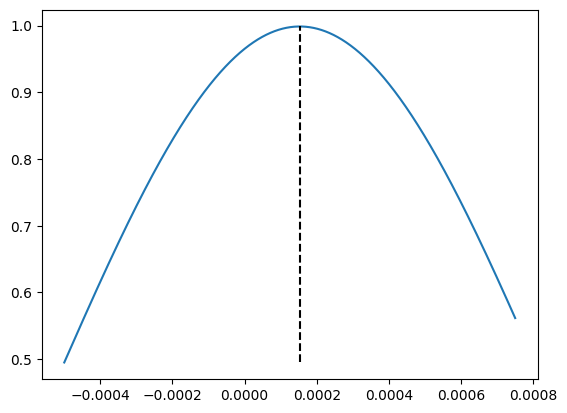

In [2]:
from xcorrRoutines import *

def test_estimate(rx1, rx2, duration, fs, td_scan_range, steeringvec=None, paddedLen=None,
                  td_scan_freqBounds=None):
    # Perform subsample time search i.e. generalised xcorr
    x_aligned = rx1[:int(np.round(duration*fs))]
    y_aligned = rx2[:int(np.round(duration*fs))] # We assume it's sample-aligned already

    if paddedLen is not None:
        x_aligned = np.hstack((x_aligned, np.zeros(paddedLen-len(x_aligned))))
        y_aligned = np.hstack((y_aligned, np.zeros(paddedLen-len(y_aligned))))

    finefreqfound, timediff, cost_vec = fineFreqTimeSearch(
        x_aligned, y_aligned,
        [], None, None, fs,
        td_scan_range, steeringvec=steeringvec, td_scan_freqBounds=td_scan_freqBounds)
    
    return timediff, cost_vec

# Test estimation once
td_scan_range = np.arange(-1/fs, 1.5/fs, 50e-9)
timediff, cost_vec = test_estimate(rx1, rx2, 
                                   rx1.size/fs, # duration, 
                                   fs, td_scan_range)

print("Estim. td = %gs" % (timediff))
print("Actual td = %gs" % (tau2-tau1))
print("Estim err = %gs" % (timediff - (tau2-tau1)))

plt.figure()
plt.plot(td_scan_range, np.abs(cost_vec))
plt.vlines(timediff, np.min(np.abs(cost_vec)), np.max(np.abs(cost_vec)), color='k', linestyle='dashed')

In [3]:
# Okay let's run it a few loops and collect results
from tqdm import tqdm

numIter = 100
timedifflist = np.zeros(numIter)

td_scan_range = np.arange(0/fs, 1.5/fs, 100e-9)
steeringvec = makeTimeScanSteervec(td_scan_range, fs, 
                                   rx1.size) # int(duration*fs))
for i in tqdm(range(numIter)):
    syms, sig, tp, rx1, rx2 = test_generate(
        length, baud, m, duration,
        pure_OSR, pure_fs,
        t,
        tau1, tau2
    )
    
    timediff, cost_vec = test_estimate(rx1, rx2, 
                                       rx1.size / fs, # duration, 
                                       fs, td_scan_range, steeringvec=steeringvec)
    timedifflist[i] = timediff

100%|██████████| 100/100 [00:03<00:00, 27.00it/s]


Maximum TD abs error:  3.7000000000000086e-06
Mean TD abs error:  2.312000000000007e-06


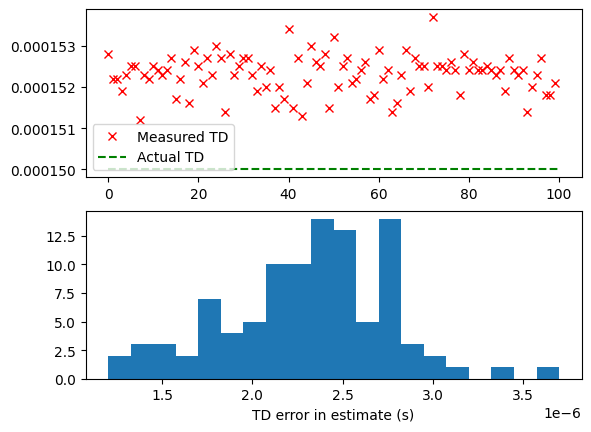

In [4]:
# Histogram of errors
efig, eax = plt.subplots(2,1)
eax[0].plot(timedifflist, 'rx', label="Measured TD")
eax[0].hlines(tau2-tau1, 0, len(timedifflist), colors='g', linestyle='dashed', label="Actual TD")
# Look at TD scan range limits?
# eax[0].hlines([td_scan_range[0], td_scan_range[-1]], 0, len(timedifflist), colors='k', linestyle='dashed', label="Scan range")
eax[0].legend()

eax[1].hist(timedifflist-(tau2-tau1), 20)
eax[1].set_xlabel("TD error in estimate (s)")

print("Maximum TD abs error: ", np.max(np.abs(timedifflist-(tau2-tau1))))
print("Mean TD abs error: ", np.mean(np.abs(timedifflist-(tau2-tau1))))
# efig.savefig("%g_%g.png" % (tau1, tau2))

## Biased Errors

What's going on here? It seems like the generalised cross-correlation estimator is returning a biased TD result, even in a noiseless scenario. You can try to change the ```tau``` values and other parameters, but you'll see that you will still get some variant of a biased result. There is also ample search range (you can uncomment the line to see where the TD scan range limits are) How do we fix this?

100%|██████████| 250/250 [00:09<00:00, 26.26it/s]


Maximum TD abs error:  3.4000000000000013e-06
Mean TD abs error:  1.1856000000000014e-06


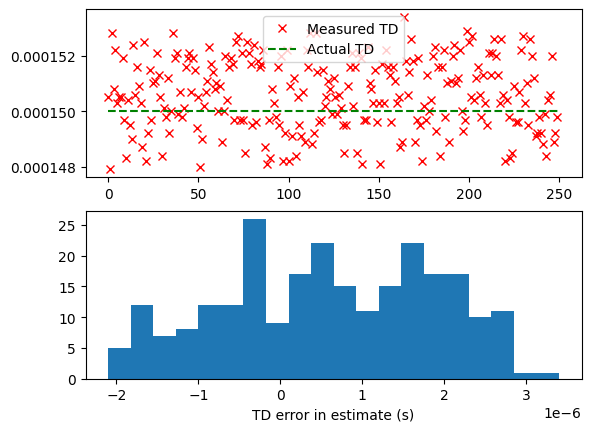

In [5]:
# Repeat the test, but add filtering before estimation (even though it's noiseless)
from tqdm import tqdm

numIter = 250
timedifflist = np.zeros(numIter)

td_scan_range = np.arange(0/fs, 1.5/fs, 100e-9)
steeringvec = makeTimeScanSteervec(td_scan_range, fs, 
                                   rx1.size) # int(duration*fs))
for i in tqdm(range(numIter)):
    syms, sig, tp, rx1, rx2 = test_generate(
        length, baud, m, duration,
        pure_OSR, pure_fs,
        t,
        tau1, tau2
    )
    
    # Some filtering
    rx1 = sps.lfilter(ftap, 1, rx1)#[ftap.size//2:]
    rx2 = sps.lfilter(ftap, 1, rx2)#[ftap.size//2:]
    
    timediff, cost_vec = test_estimate(rx1, rx2, 
                                       rx1.size/fs, # duration, 
                                       fs, td_scan_range, steeringvec=steeringvec)
    timedifflist[i] = timediff

# Histogram of errors
efig, eax = plt.subplots(2,1)
eax[0].plot(timedifflist, 'rx', label="Measured TD")
eax[0].hlines(tau2-tau1, 0, len(timedifflist), colors='g', linestyle='dashed', label="Actual TD")
# Look at TD scan range limits?
# eax[0].hlines([td_scan_range[0], td_scan_range[-1]], 0, len(timedifflist), colors='k', linestyle='dashed', label="Scan range")
eax[0].legend()

eax[1].hist(timedifflist-(tau2-tau1), 20)
eax[1].set_xlabel("TD error in estimate (s)")

print("Maximum TD abs error: ", np.max(np.abs(timedifflist-(tau2-tau1))))
print("Mean TD abs error: ", np.mean(np.abs(timedifflist-(tau2-tau1))))

## Filtering Helps Alleviate Bias

Okay, not exactly normally distributed, but at least it is more centred now, and the mean error is lower.

There's a clear issue here that we have forgotten: subsample searches using the generalised cross-correlation method relies on the FFT of the array used, and this inevitably affects the time resolution(?)/accuracy(?) of the subsample scan. This can be seen by considering the fact that a zero-padded array will have more frequency bins, and as such will have more frequency bins 'representing' the signal.

Let's compare this to the case where we propagate by an integer number of samples.

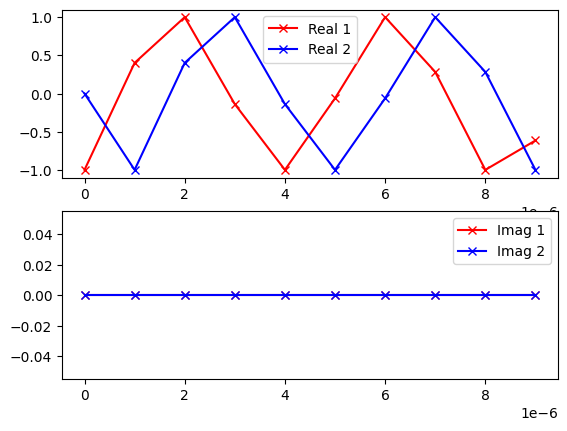

In [6]:
tau1 = 0.0 / fs
tau2 = 1.0 / fs

# Generate once to test
syms, sig, tp, rx1, rx2 = test_generate(length, baud, m, duration,
                                        pure_OSR, pure_fs,
                                        t,
                                        tau1, tau2)

# Let's make sure it really moved 1 sample
fig, ax = plt.subplots(2,1)
pLen = 10
ax[0].plot(tp[:pLen], np.real(rx1[:pLen]), 'rx-', label='Real 1')
ax[1].plot(tp[:pLen], np.imag(rx1[:pLen]), 'rx-', label='Imag 1')

ax[0].plot(tp[:pLen], np.real(rx2[:pLen]), 'bx-', label='Real 2')
ax[1].plot(tp[:pLen], np.imag(rx2[:pLen]), 'bx-', label='Imag 2')

ax[0].legend()
ax[1].legend()


100%|██████████| 250/250 [00:09<00:00, 26.97it/s]


Maximum TD abs error:  0.0
Mean TD abs error:  0.0


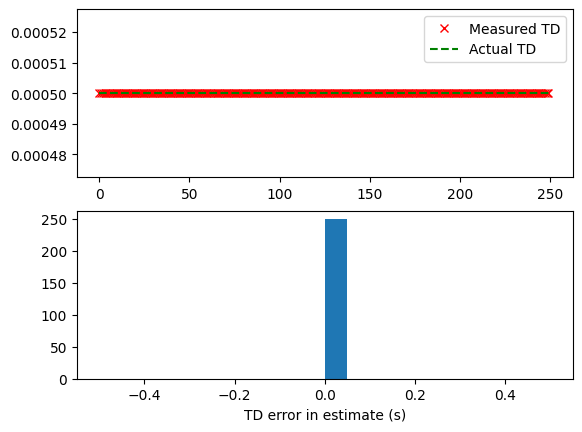

In [7]:
# Multiple estimations again..
numIter = 250
timedifflist = np.zeros(numIter)

td_scan_range = np.arange(0/fs, 1.5/fs, 100e-9)
steeringvec = makeTimeScanSteervec(td_scan_range, fs, 
                                   rx1.size)#int(duration*fs))
for i in tqdm(range(numIter)):
    syms, sig, tp, rx1, rx2 = test_generate(
        length, baud, m, duration,
        pure_OSR, pure_fs,
        t,
        tau1, tau2
    )
    
    timediff, cost_vec = test_estimate(rx1, rx2, 
                                       rx1.size / fs, # duration, 
                                       fs, td_scan_range, steeringvec=steeringvec)
    timedifflist[i] = timediff

# Histogram of errors
efig, eax = plt.subplots(2,1)
eax[0].plot(timedifflist, 'rx', label="Measured TD")
eax[0].hlines(tau2-tau1, 0, len(timedifflist), colors='g', linestyle='dashed', label="Actual TD")
# Look at TD scan range limits?
# eax[0].hlines([td_scan_range[0], td_scan_range[-1]], 0, len(timedifflist), colors='k', linestyle='dashed', label="Scan range")
eax[0].legend()

eax[1].hist(timedifflist-(tau2-tau1), 20)
eax[1].set_xlabel("TD error in estimate (s)")

print("Maximum TD abs error: ", np.max(np.abs(timedifflist-(tau2-tau1))))
print("Mean TD abs error: ", np.mean(np.abs(timedifflist-(tau2-tau1))))



## Integer Sample Time-shifts Are Okay

Alright, as expected, the propagation/estimation works for integer sample time shifts. How would we go about restoring the time-shift accuracy when using the generalised cross-correlation method i.e. the time shifts in frequency domain? 

As we noted earlier, we should be able to 'increase the frequency representation' of the signal by padding zeroes before-hand, as this would increase the number of DFT bins in total; padding to twice the length would mean twice the number of bins representing the signal (but also twice the number of bins representing the noise). Let's try this.

100%|██████████| 100/100 [00:12<00:00,  7.72it/s]


Maximum TD abs error:  2.8000000000012607e-06
Mean TD abs error:  2.031000000001263e-06


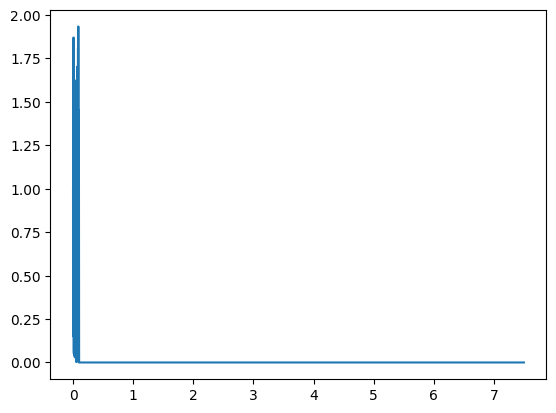

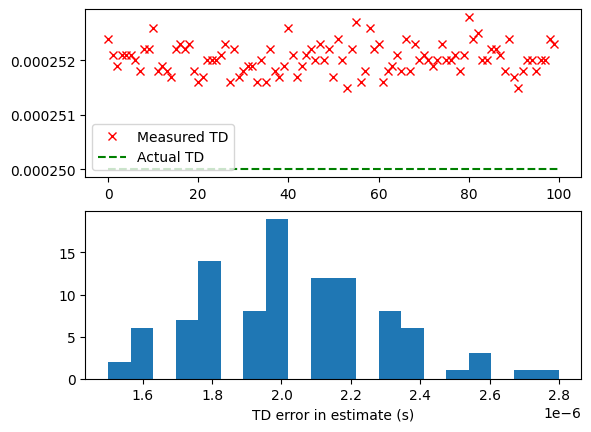

In [8]:
# Increase timevector up to 10x of before, effectively padding more zeroes
t = np.arange(int((75 * length / baud) * fs)) / fs

# Change back to subsample shifts
tau1 = 0.0 / fs
tau2 = 0.5 / fs

# Generate
syms, sig, tp, rx1, rx2 = test_generate(length, baud, m, duration,
                                        pure_OSR, pure_fs,
                                        t,
                                        tau1, tau2)

plt.figure()
plt.plot(t, np.abs(rx1))

# Multiple estimations again..
numIter = 100
timedifflist = np.zeros(numIter)

td_scan_range = np.arange(0.4/fs, 0.6/fs, 100e-9)
steeringvec = makeTimeScanSteervec(td_scan_range, fs, 
                                   rx1.size)#int(duration*fs))
for i in tqdm(range(numIter)):
    syms, sig, tp, rx1, rx2 = test_generate(
        length, baud, m, duration,
        pure_OSR, pure_fs,
        t,
        tau1, tau2
    )
    
    timediff, cost_vec = test_estimate(rx1, rx2, 
                                       rx1.size / fs, # duration, 
                                       fs, td_scan_range, steeringvec=steeringvec)
    timedifflist[i] = timediff

# Histogram of errors
efig, eax = plt.subplots(2,1)
eax[0].plot(timedifflist, 'rx', label="Measured TD")
eax[0].hlines(tau2-tau1, 0, len(timedifflist), colors='g', linestyle='dashed', label="Actual TD")
# Look at TD scan range limits?
# eax[0].hlines([td_scan_range[0], td_scan_range[-1]], 0, len(timedifflist), colors='k', linestyle='dashed', label="Scan range")
eax[0].legend()

eax[1].hist(timedifflist-(tau2-tau1), 20)
eax[1].set_xlabel("TD error in estimate (s)")

print("Maximum TD abs error: ", np.max(np.abs(timedifflist-(tau2-tau1))))
print("Mean TD abs error: ", np.mean(np.abs(timedifflist-(tau2-tau1))))

## Increasing FFT Resolution for Time-shifts via Phase Does Nothing

Nope, that didn't do anything. What if we also limit our time scanning steer vector to operate only on the signal bandwidth i.e. ignore all the spectral leakage?

100%|██████████| 100/100 [00:13<00:00,  7.53it/s]


Maximum TD abs error:  2.0000000000012412e-06
Mean TD abs error:  9.380000000008782e-07


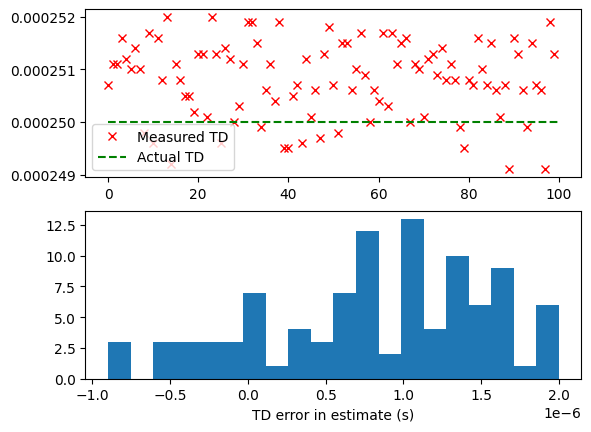

In [9]:
# Multiple estimations again..
numIter = 100
timedifflist = np.zeros(numIter)

td_scan_range = np.arange(0.4/fs, 0.6/fs, 100e-9)
steeringvec = makeTimeScanSteervec(td_scan_range, fs, 
                                   rx1.size)#int(duration*fs))
for i in tqdm(range(numIter)):
    syms, sig, tp, rx1, rx2 = test_generate(
        length, baud, m, duration,
        pure_OSR, pure_fs,
        t,
        tau1, tau2
    )
    
    timediff, cost_vec = test_estimate(rx1, rx2, 
                                       rx1.size / fs, # duration, 
                                       fs, td_scan_range, steeringvec=steeringvec,
                                       td_scan_freqBounds=[-baud/2,baud/2])
    timedifflist[i] = timediff

# Histogram of errors
efig, eax = plt.subplots(2,1)
eax[0].plot(timedifflist, 'rx', label="Measured TD")
eax[0].hlines(tau2-tau1, 0, len(timedifflist), colors='g', linestyle='dashed', label="Actual TD")
# Look at TD scan range limits?
# eax[0].hlines([td_scan_range[0], td_scan_range[-1]], 0, len(timedifflist), colors='k', linestyle='dashed', label="Scan range")
eax[0].legend()

eax[1].hist(timedifflist-(tau2-tau1), 20)
eax[1].set_xlabel("TD error in estimate (s)")

print("Maximum TD abs error: ", np.max(np.abs(timedifflist-(tau2-tau1))))
print("Mean TD abs error: ", np.mean(np.abs(timedifflist-(tau2-tau1))))

## Filtering via Zero-ing in Frequency Domain Alleviates Bias, similar to before

This seems to correlate well with our previous 'fix' where we pre-filtered the signal (this would have effectively suppressed the spectral leakage, whereas here we outright zeroed it).

Some papers have suggested using linear regressors on the phase function to perform time delay estimation; see the following:

1. Review on Time Delay Estimate Subsample Interpolation in Frequency Domain. Linas Svilainis.

I adapt this here to work 'like a generalised cross-correlation estimator', by performing the phase regression on the product of the FFTs.

[0.00025133]
0.00025
[1.32852736e-06]


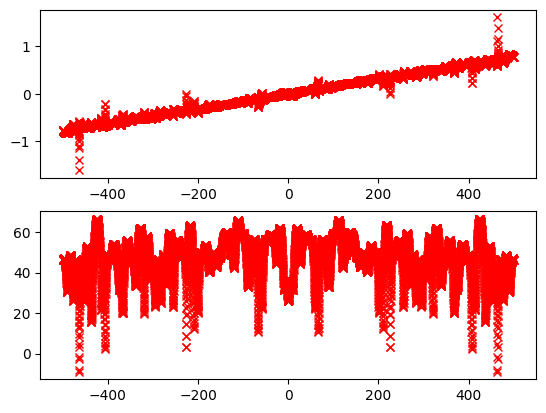

In [10]:
def quick_phase_regressor(rx1, rx2):
    xfft = np.fft.fft(rx1)
    yfft = np.fft.fft(rx2)
    freqvec = makeFreq(rx1.size, fs)

    ccf = xfft * yfft.conj()

    ccf = np.hstack((ccf[:ccf.size//4], ccf[-ccf.size//4:]))
    freqvec = np.hstack((freqvec[:freqvec.size//4], freqvec[-freqvec.size//4:]))



    # Weighted linear fit phase
    w = np.abs(ccf) # np.abs(ccf) # 1.0
    m = np.linalg.lstsq((np.sqrt(w) * freqvec).reshape((-1,1)), 
                        np.sqrt(w) * np.angle(ccf), rcond=None)[0]
    
    td = m/(2*np.pi)

    return td, ccf, freqvec

td,ccf,freqvec = quick_phase_regressor(rx1,rx2)

pfig, pax = plt.subplots(2,1)
pax[0].plot(freqvec, np.angle(ccf), 'rx')
pax[1].plot(freqvec, 20*np.log10(np.abs(ccf)), 'rx')

print(td)
print(tau2-tau1)
print(td - (tau2-tau1))


100%|██████████| 250/250 [00:04<00:00, 54.73it/s]


Maximum TD abs error:  2.288726699745927e-06
Mean TD abs error:  9.081384683873865e-07


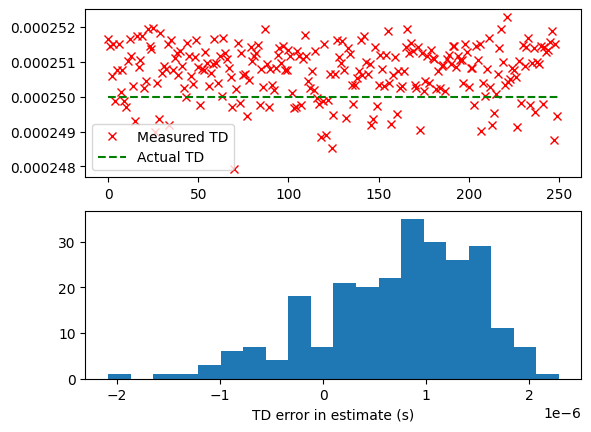

In [11]:
# Try it multiple times..
# Multiple estimations again..
numIter = 250
timedifflist = np.zeros(numIter)

for i in tqdm(range(numIter)):
    syms, sig, tp, rx1, rx2 = test_generate(
        length, baud, m, duration,
        pure_OSR, pure_fs,
        t,
        tau1, tau2
    )
    
    timediff, ccf, freqvec = quick_phase_regressor(rx1,rx2)
    timedifflist[i] = timediff

# Histogram of errors
efig, eax = plt.subplots(2,1)
eax[0].plot(timedifflist, 'rx', label="Measured TD")
eax[0].hlines(tau2-tau1, 0, len(timedifflist), colors='g', linestyle='dashed', label="Actual TD")
# Look at TD scan range limits?
# eax[0].hlines([td_scan_range[0], td_scan_range[-1]], 0, len(timedifflist), colors='k', linestyle='dashed', label="Scan range")
eax[0].legend()

eax[1].hist(timedifflist-(tau2-tau1), 20)
eax[1].set_xlabel("TD error in estimate (s)")

print("Maximum TD abs error: ", np.max(np.abs(timedifflist-(tau2-tau1))))
print("Mean TD abs error: ", np.mean(np.abs(timedifflist-(tau2-tau1))))


## Phase Regressions Is Equivalent to the Generalised Cross-Correlation Dot Products+Filtering

So the phase regression seems to exhibit the same slight bias as when the generalised cross-correlation was performed with filters, due to the slicing of the phase values to be restricted to in-band. Back to square one..

## The Problem is With The Estimator

It turns out we can reproduce this bias problem even if we propagate a signal in time with the FFT phase method, and then extract a slice of the signal to perform estimation.

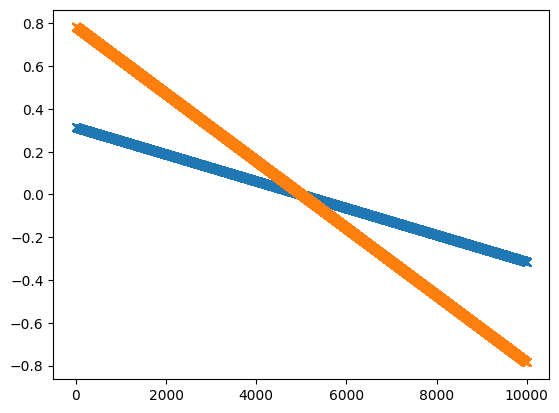

In [17]:
# Main generation function
def test_fft_propagate(length, m, osr, tau_samples1, tau_samples2, fs):
    
    # Create some symbols
    syms, bits = randPSKsyms(length, m)

    # Resample to some OSR
    sig = sps.resample_poly(syms, osr, 1)

    # Propagate in time via the FFT phase
    rx1 = propagateSignal(sig, tau_samples1, fs)[0]
    rx2 = propagateSignal(sig, tau_samples2, fs)[0]

    return syms, sig, rx1, rx2


# Generate some test data
length = 10000
fs = 10000
tau1 = 0.1e-4
tau2 = 0.25e-4
syms, sig, rx1, rx2 = test_fft_propagate(length, 2, 1, tau1, tau2, fs)

# Check the phase difference plots 0.0001, 0.0002
ccf1 = np.fft.fft(rx1) * np.fft.fft(sig).conj()
ccf2 = np.fft.fft(rx2) * np.fft.fft(sig).conj()

# Sanity check that the phase differences are linear as we intended
plt.figure()
plt.plot(np.angle(np.fft.fftshift(ccf1)), 'x')
plt.plot(np.angle(np.fft.fftshift(ccf2)), 'x')

The above shows that our simulation produces the constant group delay on all frequency components, as we intended. Now let's slice a part of the data and perform estimation on it.

The question here is: although we engineered a constant group delay at the entire signal level, does this ensure that the group delay of an arbitrary slice is identical?

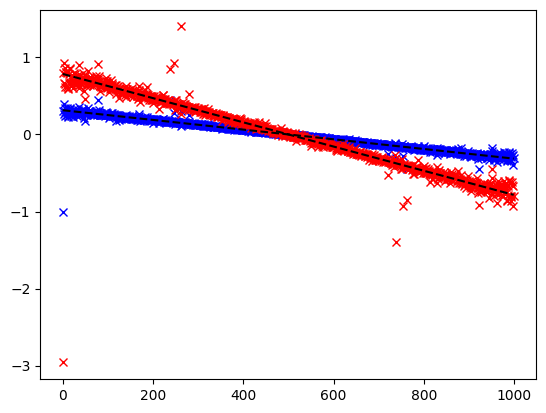

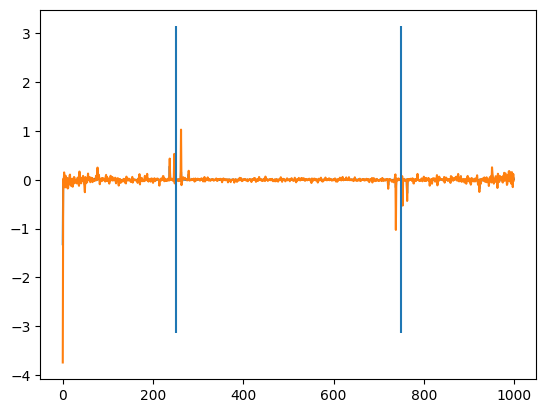

In [22]:
sigslice = sig[0:1000]
slice1 = rx1[0:1000]
slice2 = rx2[0:1000]

ccf1 = np.fft.fft(slice1) * np.fft.fft(sigslice).conj()
ccf2 = np.fft.fft(slice2) * np.fft.fft(sigslice).conj()

plt.figure()
ccf1angle = np.angle(np.fft.fftshift(ccf1))
ccf2angle = np.angle(np.fft.fftshift(ccf2))
plt.plot(ccf1angle, 'bx')
plt.plot(ccf2angle, 'rx')
theophase1 = np.fft.fftshift(-makeFreq(1000, fs) * 2*np.pi * tau1)
theophase2 = np.fft.fftshift(-makeFreq(1000, fs) * 2*np.pi * tau2)
plt.plot(theophase1, 'k--')
plt.plot(theophase2, 'k--')

# Compute mean phase error
plt.figure()
plt.plot(ccf1angle - theophase1)
plt.plot(ccf2angle - theophase2)
plt.vlines([ccf1angle.size/4, ccf1angle.size/4*3], -np.pi, np.pi)

1.001684427992399e-05
1e-05
2.5056673555682866e-05
2.5e-05


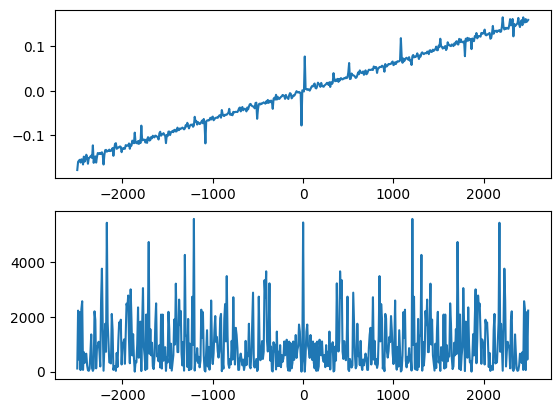

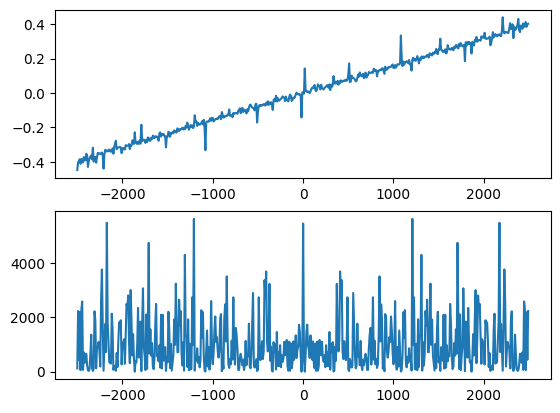

In [43]:
def quick_phase_regressor(rx1, rx2):
    # Pad zeroes? # This doesn't help, the artifacts appear everywhere now
    rx1 = np.pad(rx1, (0,100))
    rx2 = np.pad(rx2, (0,100))

    xfft = np.fft.fft(rx1)
    yfft = np.fft.fft(rx2)
    freqvec = makeFreq(rx1.size, fs)

    ccf = xfft * yfft.conj()

    ccf = np.hstack((ccf[-ccf.size//4:], ccf[:ccf.size//4]))
    freqvec = np.hstack((freqvec[-freqvec.size//4:], freqvec[:freqvec.size//4]))

    fig, ax = plt.subplots(2,1)
    ax[0].plot(freqvec, np.angle(ccf))
    ax[1].plot(freqvec, np.abs(ccf))
    
    # Weighted linear fit phase
    w = np.abs(ccf) # np.abs(ccf) # 1.0
    m = np.linalg.lstsq((np.sqrt(w) * freqvec).reshape((-1,1)), 
                        np.sqrt(w) * np.angle(ccf), rcond=None)[0]

    
    td = m/(2*np.pi)

    return td, ccf, freqvec

td,ccf,freqvec = quick_phase_regressor(sigslice, slice1)
print(td[0])
print(tau1)
td,ccf,freqvec = quick_phase_regressor(sigslice, slice2)
print(td[0])
print(tau2)


## Phase of Slices of Noiseless Signals Display Large Correlated Phase Shifts

We see above that even dropping the tail ends of the phase plots and performing regression may still produce artifacts, which are correlated (errors upwards on positive frequencies, errors downwards on negative frequencies). This in turn causes a noticeable non-zero mean error of the $\tau$ estimator as the gradient is shifted in a particular direction.

Furthermore, padding zeroes doesn't remove the artifacts; they are not caused by circular convolutions messing up the phase information.